Training samples:  torch.Size([1, 41, 41])
Label samples:  torch.Size([1, 41, 41])


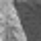

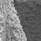

In [ ]:
# get dataset
import h5py
from sklearn.model_selection import train_test_split
import torch
import numpy as np
from PIL import Image
from torchvision import transforms

file = h5py.File('train.h5', 'r')

in_train = file['data'][:]
out_train = file['label'][:]
file.close()

in_train = in_train.astype('float32')
out_train = out_train.astype('float32')

tfPIL = transforms.ToPILImage()
tfTensor = transforms.ToTensor()
scale_factor = 2

for i in range(len(in_train)):
  hr_img = torch.Tensor(in_train[i])
  hr_c, hr_h, hr_w = hr_img.shape
  hr_img = tfPIL(hr_img)

  lr_img = hr_img.resize(((hr_h // scale_factor), (hr_w // scale_factor)), Image.BICUBIC)
  lr_img = lr_img.resize((hr_h, hr_w), Image.BICUBIC)

  lr_img = tfTensor(lr_img)
  in_train[i] = lr_img.numpy()
  
(x_train, x_val, y_train, y_val) = train_test_split(in_train, out_train, test_size=0.25)

img = torch.Tensor(x_train[0])
label = torch.Tensor(y_train[0])

print('Training samples: ', img.shape)
print('Label samples: ', label.shape)

tf = transforms.ToPILImage()
img = tf(img)
label = tf(label)

display(img)
display(label)

In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch
from PIL import Image
from torchvision import transforms

batch_size = 64

class VDSRDataset(Dataset):
  def __init__(self, image_data, labels):
    self.image_data = image_data
    self.labels = labels

  def __len__(self):
    return len(self.image_data)

  def __getitem__(self, idx):
    image = self.image_data[idx]
    label = self.labels[idx]
    return (
        torch.tensor(image, dtype=torch.float),
        torch.tensor(label, dtype=torch.float)
    )

train_data = VDSRDataset(x_train, y_train)
val_data = VDSRDataset(x_val, y_val)

train_loader = DataLoader(train_data, batch_size=batch_size)
val_loader = DataLoader(val_data, batch_size=batch_size)

img, label = next(iter(train_loader))
print('Train batch sample: ', img[0].shape, label[0].shape)
print(torch.equal(img[0], label[0]))
print(img[0])
print(label[0])

Train batch sample:  torch.Size([1, 41, 41]) torch.Size([1, 41, 41])
False
tensor([[[0.6667, 0.6549, 0.6353,  ..., 0.4078, 0.4157, 0.4157],
         [0.6588, 0.6471, 0.6275,  ..., 0.4000, 0.4078, 0.4078],
         [0.6392, 0.6314, 0.6157,  ..., 0.3882, 0.3922, 0.3961],
         ...,
         [0.7451, 0.7137, 0.6510,  ..., 0.3176, 0.3255, 0.3255],
         [0.7922, 0.7490, 0.6510,  ..., 0.3451, 0.3451, 0.3451],
         [0.8118, 0.7608, 0.6510,  ..., 0.3569, 0.3529, 0.3529]]])
tensor([[[0.6588, 0.6471, 0.6510,  ..., 0.4078, 0.4078, 0.4157],
         [0.6627, 0.6588, 0.6392,  ..., 0.4000, 0.4118, 0.4157],
         [0.6196, 0.7059, 0.6039,  ..., 0.4118, 0.3882, 0.3765],
         ...,
         [0.8745, 0.7490, 0.6667,  ..., 0.3216, 0.3020, 0.3098],
         [0.8902, 0.6824, 0.5882,  ..., 0.3647, 0.3529, 0.3294],
         [0.8392, 0.7569, 0.6392,  ..., 0.3490, 0.3608, 0.3647]]])


In [ ]:
# get model
import vdsr

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model = vdsr.VDSR().to(device)
# print(model)

cuda


In [ ]:
# define hyperparameters
import torch.optim as optim
import torch.nn as nn
import numpy
import math

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
criterion = nn.MSELoss()

epochs = 50

def psnr(label, outputs, max_val=1.):
  '''
  PSNR = 20 * log10(MAXp) - 10 * log10(MSE)
  '''
  label = label.cpu().detach().numpy()
  outputs = outputs.cpu().detach().numpy()
  img_diff = outputs - label
  rmse = math.sqrt(numpy.mean(img_diff ** 2))

  if rmse == 0:
    return 100
  else:
    PSNR = 20 * math.log10(max_val / rmse)
    return PSNR

In [ ]:
# define train, validation function
from tqdm import tqdm

def train(model, dataloader):
  model.train()
  running_loss, running_psnr = 0.0, 0.0

  for ii, data in enumerate(dataloader):
    image_data = data[0].to(device)
    label = data[1].to(device)

    optimizer.zero_grad()


    outputs = model(image_data)
    loss = criterion(outputs, label)
    
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.4)
    
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    batch_psnr = psnr(label, outputs)
    running_psnr += batch_psnr
  
  final_loss = running_loss / len(dataloader.dataset)
  final_psnr = running_psnr / int(len(train_data) / dataloader.batch_size)
  return final_loss, final_psnr

def validate(model, dataloader):
  model.eval()
  running_loss, running_psnr = 0.0, 0.0

  with torch.no_grad():
    for ii, data in enumerate(dataloader):
      image_data = data[0].to(device)
      label = data[1].to(device)

      outputs = model(image_data)
      loss = criterion(outputs, label)

      running_loss += loss.item()
      batch_psnr = psnr(label, outputs)
      running_psnr += batch_psnr
    outputs = outputs.cpu()

  final_loss = running_loss / len(dataloader.dataset)
  final_psnr = running_psnr / int(len(val_data) / dataloader.batch_size)
  return final_loss, final_psnr


>>> Epoch 1 of 50
Train PSNR: 31.437
Val PSNR: 38.256
>>> Epoch 2 of 50
Train PSNR: 31.465
Val PSNR: 38.295
>>> Epoch 3 of 50
Train PSNR: 31.497
Val PSNR: 38.333
>>> Epoch 4 of 50
Train PSNR: 31.527
Val PSNR: 38.366
>>> Epoch 5 of 50
Train PSNR: 31.554
Val PSNR: 38.396
>>> Epoch 6 of 50
Train PSNR: 31.579
Val PSNR: 38.425
>>> Epoch 7 of 50
Train PSNR: 31.605
Val PSNR: 38.453
>>> Epoch 8 of 50
Train PSNR: 31.630
Val PSNR: 38.483
>>> Epoch 9 of 50
Train PSNR: 31.655
Val PSNR: 38.513
>>> Epoch 10 of 50
Train PSNR: 31.678
Val PSNR: 38.541
>>> Epoch 11 of 50
Train PSNR: 31.693
Val PSNR: 38.544
>>> Epoch 12 of 50
Train PSNR: 31.696
Val PSNR: 38.547
>>> Epoch 13 of 50
Train PSNR: 31.698
Val PSNR: 38.549
>>> Epoch 14 of 50
Train PSNR: 31.700
Val PSNR: 38.552
>>> Epoch 15 of 50
Train PSNR: 31.702
Val PSNR: 38.555
>>> Epoch 16 of 50
Train PSNR: 31.704
Val PSNR: 38.557
>>> Epoch 17 of 50
Train PSNR: 31.707
Val PSNR: 38.560
>>> Epoch 18 of 50
Train PSNR: 31.709
Val PSNR: 38.562
>>> Epoch 19 of 50


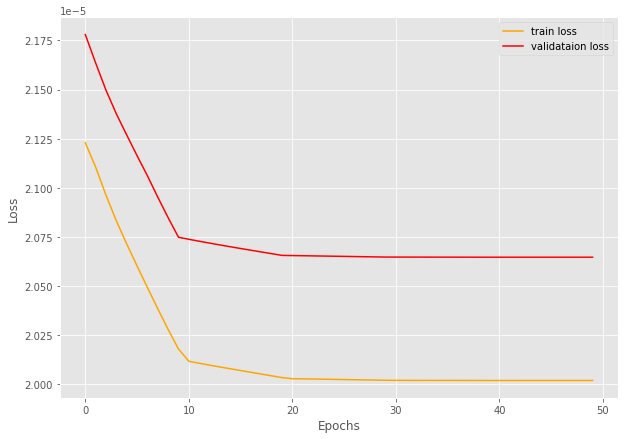

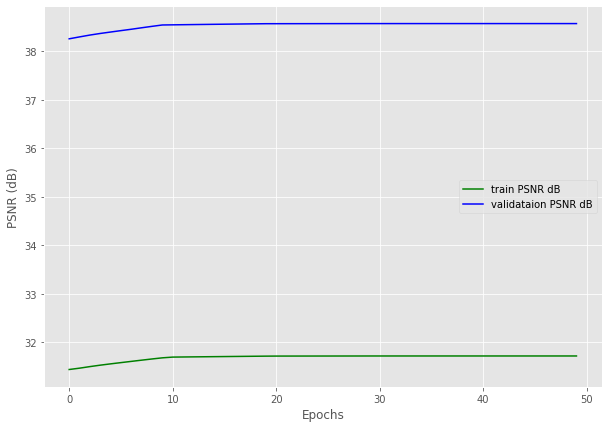

Saving model...


In [ ]:
# train, validate model
from time import time
import matplotlib
import matplotlib.pyplot as plt

train_loss, val_loss = [], []
train_psnr, val_psnr = [], []

start = time()
for epoch in range(epochs):
  print(f'>>> Epoch {epoch + 1} of {epochs}')

  train_epoch_loss, train_epoch_psnr = train(model, train_loader)
  val_epoch_loss, val_epoch_psnr = validate(model, val_loader)
  print(f'Train PSNR: {train_epoch_psnr:.3f}')
  print(f'Val PSNR: {val_epoch_psnr:.3f}')

  train_loss.append(train_epoch_loss)
  val_loss.append(val_epoch_loss)
  train_psnr.append(train_epoch_psnr)
  val_psnr.append(val_epoch_psnr)

  scheduler.step()
end = time()
print(f'Finished Training in: {((end - start) / 60):.3f} minutes')

matplotlib.style.use('ggplot')

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('../outputs/loss.png')
plt.show()
# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.plot(val_psnr, color='blue', label='validataion PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.savefig('../outputs/psnr.png')
plt.show()
# save the model to disk
print('Saving model...')
torch.save(model.state_dict(), f'../outputs/model_epoch_{epochs}.pth')